In [1]:
import json
from dataclasses import dataclass, asdict
import numpy as np
from observer import CalibratedObserver, CameraChange, TrackedObject, CalibratedCaptureConfiguration, Transition, distanceFormula
import dma.MechaCombat as mc
from dma.MechaCombat import GameEvent, GameState, Skill, Mech
QuantumSystem = mc.QuantumSystem
qs = QuantumSystem

In [2]:
@dataclass
class HarmonyObject(TrackedObject):
    oid: str = None
    objectType: str = None
    objectSubType: str = None
    objectKwargs: dict = None

    objectFactories = {"Unit": mc.MechFactories, "Structure": mc.StructureFactories, "Terrain": mc.TerrainFactories}
    
    def __post_init__(self):
        super().__post_init__()
        print(f"Creating {self.objectType} -- {self.objectSubType} -- {self.objectKwargs}")
        self.objectKwargs = {key.lower(): value for key, value in self.objectKwargs.items()}
        try:
            factory = self.objectFactories[self.objectType][self.objectSubType]
        except KeyError as ke:
            raise Exception(f"Unrecognized object type and subtype - {self.objectType}-{self.objectSubType}")
        factory(self.oid, **self.objectKwargs)
        GameState.addObject(self.oid, self.objectType)

    @classmethod
    def from_tracked_object(cls,
                            trackedObject: TrackedObject,
                            objectType: str,
                            objectSubType: str,
                            objectKwargs: dict):
        # if not qs.entity_exists(trackedObject.oid):
        print(f"Creating {objectType} object from {trackedObject}")
        return cls(
            changeSet=trackedObject.changeSet,
            oid=trackedObject.oid,
            objectType=objectType,
            objectSubType=objectSubType,
            objectKwargs=objectKwargs)
        
    def previousVersion(self):
        return TrackedObject({camName: change.lastChange if change is not None else None for camName, change in self.changeSet.items()})

    def rename(self, newName):
        qs.rename_entity(self.oid, newName)
        self.oid = newName

In [3]:
@dataclass
class ObjectAction:
    actor: HarmonyObject
    target: HarmonyObject
    result: str = "null"
    
    def __post_init__(self):
        assert self.rsc is not None, f"Object Actions require a RealSpace Converter"
        if self.target is None:
            self.targetDistance = None
            self.targetRange = None
            self.rangeModifier = None
            self.objMovement = None
            self.aMM = None
            self.targetMovement = None
            self.tMM = None
            self.skill = None
            self.targetNumber = None
            self.gameEvent = None
            return
        self.targetDistance = self.rsc.distanceBetweenObjects(self.actor, self.target)
        self.targetRange = "short" if self.targetDistance < 155 else "medium" if self.targetDistance < 610 else "long"
        self.rangeModifier = 0 if "short" else 2 if "medium" else 4

        self.objMovement = self.rsc.trackedObjectLastDistance(self.actor)
        self.aMM = -1 if self.objMovement is None or self.objMovement < 10 else 1
        self.targetMovement = self.rsc.trackedObjectLastDistance(self.target)
        self.tMM = -1 if self.targetMovement is None or self.targetMovement < 10 else 1
        self.skill = Skill(self.actor.oid).terminant
        self.targetNumber = int(self.skill) + self.aMM + self.tMM + 0 + self.rangeModifier
        self.gameEvent = None

    def declare(self):
        self.gameEvent = GameEvent.declareEvent("Attack", "Unaligned", self.actor.oid, self.target.oid, self.result)

    def resolve(self, result):
        self.gameEvent.resolve(result)

In [4]:
class HarmonyMachine(CalibratedObserver):
    def reset(self):
        super().reset()
        mc.GameState.reset()
        self.GameState = mc.GameState
        ObjectAction.rsc = self.cc.rsc

    def declareEvent(self, eventType: str, eventFaction: str, eventObject: str, eventValue: str, eventResult: str):
        mc.GameState.declareEvent(eventType, eventFaction, eventObject, eventValue, eventResult)
    
    def classifyObject(self, objectId: str, objectType: str, objectSubType:str , objectKwargs: dict):
        trackedObject = self.findObject(objectId)
        memoryIndex = self.memory.index(trackedObject)
        harmonyObject = HarmonyObject.from_tracked_object(
            trackedObject, objectType, objectSubType, objectKwargs)
        mc.XYLocation.set_relationship(harmonyObject.oid, self.cc.rsc.changeSetToRealCenter(harmonyObject))
        self.memory[memoryIndex] = harmonyObject
        return harmonyObject

    def captureRealCoord(self, capture):
        """ movement distance this round """
        return self.cc.rsc.changeSetToRealCenter(capture)

    def captureSystemCoord(self, capture):
        return mc.XYLocation(capture.oid)

    def commitChanges(self, objDef, overwrite=True):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            print(f"Updating Memory {existingIndex}")
            self.memory[existingIndex].update(objDef, overwrite=overwrite)
        except ValueError:
            print(f"New Memory")
            if GameState.getPhase() != "Add":
                raise Exception("Cannot make new memories outside of Add Phase")
            self.memory.append(objDef)
            existingIndex = len(self.memory) - 1
        self.lastMemory = objDef
        
        self.transitions.append(Transition(
            objDef,
            self.cycleCounter,
            {camName: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
             for camName, cam in self.cc.cameras.items()}))
    
        if isinstance(objDef, HarmonyObject):
            systemCoord = self.captureSystemCoord(objDef)
            realCoord = self.captureRealCord(objDef)
            delta = [d1 - d0 for d0, d1 in zip(systemCoord, realCoord)]
            delta.append(0)  # TODO: get elevation change from terrain
            if mc.Move.can_move(objDef, delta):
                self.declareEvent(
                    eventType="Move",
                    eventFaction=mc.Faction(objDef.oid),
                    eventObject=objDef.oid,
                    eventValue=json.dumps(delta),
                    eventResult=json.dumps(realCoord))
        return objDef

    def takeAction(self, actor, target, result=None):
        return ObjectAction(actor, target, result=result)

    def distanceFromRealPoint(self, harmonyObject: HarmonyObject, realPoint: (float, float)):
        # TODO: object at realpoint? Elevation at realpoint?
        objectLocation = mc.XYLocation(harmonyObject.oid).terminant
        return distanceFormula(objectLocation, realPoint)

    def objectLastDistance(self, harmonyObject: HarmonyObject):
        if mc.GameState.getPhase() == "Move":
            currentLocation = self.cc.rsc.changeSetToRealCenter(harmonyObject)
            return self.distanceFromRealPoint(harmonyObject, currentLocation) * 0.03937008
        else:
            return mc.DistanceMoved(harmonyObject.oid).terminant

    def objectHasMoved(self, harmonyObject: HarmonyObject):
        if self.objectLastDistance(harmonyObject) > 0.3:
            return True
        return False

    def unitsMovedThisRound(self):
        mechs = Mech.active_mechs()
        moved = []
        for m in mechs:
            harmonyObject = self.findObject(m)
            if self.objectHasMoved(harmonyObject):
                moved.append(m)
        return moved

    def objectHasDeclared(self, harmonyObject):
        if len(GameEvent.get_existing_declarations(harmonyObject.oid)) > 0:
            return True
        return False

    def unitsDeclaredThisRound(self):
        mechs = Mech.entities()
        declared = []
        for m in mechs:
            harmonyObject = self.findObject(m)
            if self.objectHasDeclared(harmonyObject):
                declared.append(m)
        return declared

    def objectHasResolved(self, harmonyObject):
        for re in GameEvent.get_resolved_events():
            if harmonyObject.oid == re.GameEventObject.terminant:
                return True
        return False

    def actionsToResolve(self):
        declared_actions = len(app.cm.unitsDeclaredThisRound())
        no_actions = len(GameEvent.get_declared_no_action_events())
        return declared_actions - no_actions

    def commitMovement(self):
        self.passiveMode()
        for entity in mc.Movement.entities():
            obj = self.findObject(entity)
            if self.objectHasMoved(obj):
                mc.Move.move_to(entity=entity, newLocation=[*self.cc.rsc.changeSetToRealCenter(obj), 0])
        mc.GameState.newPhase("Move")

    def resolveRound(self):
        for entity in mc.Movement.entities():
            mc.DistanceMoved.set_relationship(entity, 0)
        mc.GameState.newPhase("Action")
        self.trackMode()

    def units(self):
        return mc.Mech.entities()

    def active_units(self):
        return mc.Mech.active_mechs()

    def obj_destroyed(self, oid: str):
        return mc.UnitDamage.is_destroyed(entity=oid)

    def mech_skill(self, mech_oid: str):
        return mc.Skill(mech_oid).terminant

    def factions(self):
        return mc.Faction.terminants()

    def faction(self, oid: str):
        return mc.Faction(oid).terminant

    def object_type(self, oid: str):
        return mc.GameObject(oid).terminant

    def line_of_sight(self, actor: HarmonyObject, target: HarmonyObject):
        print(f"Checking LoS for {actor.oid} to {target.oid}")
        return self.cc.line_of_sight(actor, target, self.memory)

    def buildMiniMap(self, yellowObjects=None, blueObjects=None, greenObjects=None):
        return self.cc.buildMiniMap(yellowObjects=yellowObjects, blueObjects=blueObjects, greenObjects=greenObjects)

    def changeOverlaps(self, camera, change):
        changes = [m.changeSet[camera.camName] for m in self.memory if self.object_type(m.oid) in [None, "Unit"]]
        overlaps = []
        for eC in changes:
            if eC.changeType is not None and eC.changeOverlap(change) and eC not in overlaps:
                overlaps.append(eC)
        return overlaps

    def objectElevation(self, obj):
        terrainAndBuildings = [m for m in self.memory if self.object_type(m.oid) in ["Terrain", "Structure"]]
        # Determine overlaps
        overlap = None
        return 0 if overlap is None else mc.Elevation(overlap.oid).terminant
    
    @staticmethod
    def numpy_serializer(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        raise TypeError(f"Type {type(obj)} not serializable")
        
    def saveGame(self, gameName="harmony"):
        gameState = {
            "objectMemory": [asdict(m) for m in self.memory],
            "gameGraph": mc.qs.whole_graph()}
        with open(f"{gameName}.harmony", "w") as f:
            f.write(json.dumps(gameState, default=self.numpy_serializer, indent=2))
    
    def numpyizeDeserializedCameraChange(self, deserializedCameraChange: dict):
        if deserializedCameraChange['camName'] is not None:
            deserializedCameraChange['changeContours'] = [np.array(contour, dtype=np.int32) for contour in deserializedCameraChange['changeContours']]
            deserializedCameraChange['after'] = np.array(deserializedCameraChange['after'], dtype=np.int32)
            deserializedCameraChange['before'] = np.array(deserializedCameraChange['before'], dtype=np.int32)
            deserializedCameraChange['lastChange'] = self.numpyizeDeserializedCameraChange(deserializedCameraChange['lastChange'])
        return CameraChange(**deserializedCameraChange)
        
    def loadGame(self, gameName="harmony"):
        self.reset()
        with open(f"harmony.harmony", "r") as f:
            gameData = json.loads(f.read())
    
        for m in gameData['objectMemory']:
            m['changeSet'] = {cam: self.numpyizeDeserializedCameraChange(camChange) for cam, camChange in m['changeSet'].items()}
        self.memory = [HarmonyObject(**m) for m in gameData['objectMemory']]
    
        for rel in gameData['gameGraph']:
            mc.qs.put(*rel)

Starting Cycle     0 -- CapMac -- passive idle


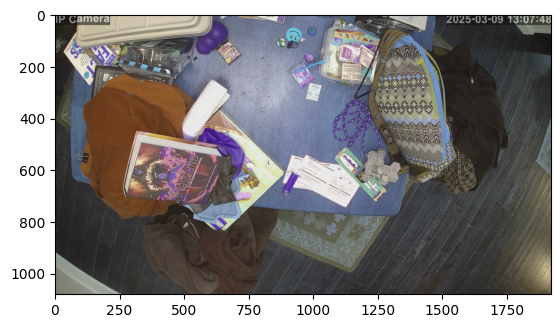

In [5]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    cc = CalibratedCaptureConfiguration()
    hm = HarmonyMachine(cc)
    hm.cycle()
    plt.imshow(cc.cameras['0'].mostRecentFrame)

Starting Cycle     1 -- CapMac -- track idle
Starting Cycle     2 -- CapMac -- track idle
Starting Cycle     3 -- CapMac -- track idle
Starting Cycle     4 -- CapMac -- track idle
Starting Cycle     5 -- CapMac -- track idle
Starting Cycle     6 -- CapMac -- track idle
Starting Cycle     7 -- CapMac -- track idle
Starting Cycle     8 -- CapMac -- track idle
Starting Cycle     9 -- CapMac -- track idle
Starting Cycle    10 -- CapMac -- track idle
Starting Cycle    11 -- CapMac -- track idle
Starting Cycle    12 -- CapMac -- track idle
Starting Cycle    13 -- CapMac -- track idle
Starting Cycle    14 -- CapMac -- track idle
Starting Cycle    15 -- CapMac -- track idle
Starting Cycle    16 -- CapMac -- track unstable
Starting Cycle    17 -- CapMac -- track unstable
Starting Cycle    18 -- CapMac -- track classify
New Memory
Starting Cycle    19 -- CapMac -- track idle
Starting Cycle    20 -- CapMac -- track idle
Starting Cycle    21 -- CapMac -- track idle
Starting Cycle    22 -- CapMac -

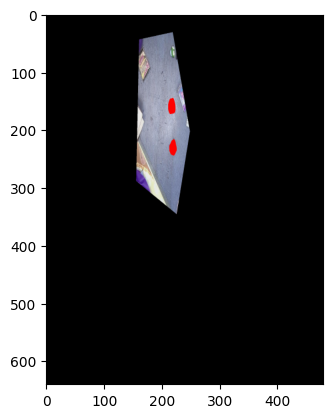

In [6]:
if __name__ == "__main__":
    for i in range(3):
        hm.cycleForChange()
    for i in range(3):
        hm.cycle()

    hm.classifyObject(hm.memory[0].oid, objectType="Unit", objectSubType="Kingfisher Prime", objectKwargs={"Faction": "Foo", "Skill": 4})
    hm.memory[0].rename("Gypsy Danger")
    hm.classifyObject(hm.memory[1].oid, objectType="Unit", objectSubType="Atlas", objectKwargs={"Faction": "Bar", "Skill": 4})
    hm.memory[1].rename("Cherno")
    plt.imshow(hm.getCameraImagesWithChanges()['0'])

Saving game with 2 memories
Reset Game Engine:



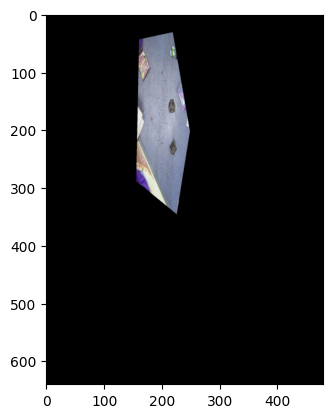

Creating Unit -- Kingfisher Prime -- {'faction': 'Foo', 'skill': 4}
Creating Unit -- Atlas -- {'faction': 'Bar', 'skill': 4}
Reloaded Game Engine:
HarmonyObject(changeSet={'0': (move) [np.float32(873.0), np.float32(273.0)] by 59.0,56.0}, oid='Gypsy Danger', objectType='Unit', objectSubType='Kingfisher Prime', objectKwargs={'faction': 'Foo', 'skill': 4})
HarmonyObject(changeSet={'0': (add) [np.float32(882.0), np.float32(394.0)] by 60.0,56.0}, oid='Cherno', objectType='Unit', objectSubType='Atlas', objectKwargs={'faction': 'Bar', 'skill': 4})


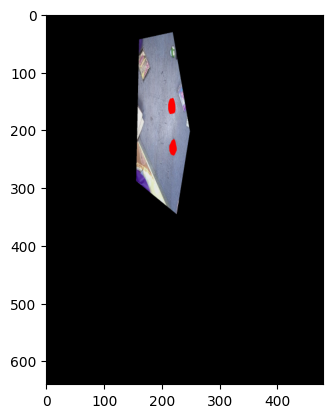

In [9]:
if __name__ == "__main__":
    print(f"Saving game with {len(hm.memory)} memories")
    hm.saveGame()
    hm.reset()
    print("Reset Game Engine:")
    print("\n".join([f"{m}" for m in hm.memory]))
    plt.imshow(hm.getCameraImagesWithChanges()['0'])
    plt.show()
    hm.loadGame()
    print("Reloaded Game Engine:")
    print("\n".join([f"{m}" for m in hm.memory]))
    plt.imshow(hm.getCameraImagesWithChanges()['0'])
    plt.show()
    mc.qs.whole_graph()